In [69]:
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor


class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.param = trees_parameters
        self.models = []
        self.features = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        X_val : numpy ndarray
            Array of size n_val_objects, n_features
        y_val : numpy ndarray
            Array of size n_val_objects
        """
        if self.feature_subsample_size is None:
            self.feature_subsample_size = X.shape[1] // 3
        if not(X_val is None):
            history = {'time':[], 'rmse': []}
            start_time = timeit.default_timer()
            y_pred = np.zeros(y_val.shape)
        for i in range(self.n_estimators):
            Ind = np.random.randint(low=0, high=X.shape[0], size=X.shape[0])
            Feat = np.random.choice(X.shape[1], size=self.feature_subsample_size, replace=False)
            model = DecisionTreeRegressor(max_depth=self.max_depth, **self.param)
            model.fit(np.take(X[Ind], Feat, axis=1), y[Ind])
            self.models.append(model)
            self.features.append(Feat)
            if not(X_val is None):
                y_pred += model.predict(np.take(X_val, Feat, axis=1))
                rmse = np.sqrt(((((y_pred/(i+1)) - y_val)**2).mean()))
#                 y_pred = self.predict(X_val)
#                 rmse = math.sqrt((((y_pred - y_val)**2).mean()))
                history['rmse'].append(rmse)
                history['time'].append(timeit.default_timer() - start_time)
        if not(X_val is None):
            return history

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        pred = np.empty((X.shape[0], self.n_estimators))
        for i in range(len(self.models)):
            pred[:, i] = self.models[i].predict(np.take(X, self.features[i], axis=1))
        return pred.mean(axis=1)

class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        learning_rate : float
            Use alpha * learning_rate instead of alpha
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.param = trees_parameters
        self.models = []
        self.alpha = []
        self.features = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        
        if self.feature_subsample_size is None:
            self.feature_subsample_size = X.shape[1] // 3
        if not(X_val is None):
            history = {'time':[], 'rmse': []}
            start_time = timeit.default_timer()
        Feat = np.random.choice(X.shape[1], size=self.feature_subsample_size, replace=False)
        g = y
        model = DecisionTreeRegressor(max_depth=self.max_depth, **self.param)
        model.fit(np.take(X, Feat, axis=1), g)
        self.models.append(model)
        self.alpha.append(1)
        self.features.append(Feat)
        pred = self.predict(X)
        g = y - pred
        if not(X_val is None):
                y_pred = model.predict(X_val[:, Feat]) 
                rmse = np.sqrt((((y_pred - y_val) **2).mean()))
                history['rmse'].append(rmse)
                history['time'].append(timeit.default_timer() - start_time)
        for i in range(self.n_estimators - 1):
            Feat = np.random.choice(X.shape[1], size=self.feature_subsample_size, replace=False)
            model = DecisionTreeRegressor(max_depth=self.max_depth, **self.param)
            model.fit(np.take(X, Feat, axis=1), g)
            y_new = model.predict(np.take(X, Feat, axis=1))
            def func(alpha):
                return ((pred + alpha * y_new - y) ** 2).sum()
#             alpha = minimize_scalar(lambda x: ((pred + x * self.learning_rate * y_new - y) ** 2).mean()).x
            alpha = minimize_scalar(func).x
            self.models.append(model)
            self.alpha.append(alpha)
            self.features.append(Feat)
            pred += self.learning_rate * alpha * y_new
            g = y - pred
            if not(X_val is None):
                y_pred += alpha * self.learning_rate * model.predict(np.take(X_val, Feat, axis=1))
                rmse = np.sqrt((((y_pred - y_val) **2).mean()))
                history['rmse'].append(rmse)
                history['time'].append(timeit.default_timer() - start_time)
        if not(X_val is None):
            return history

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        pred = self.alpha[0] * self.models[0].predict(np.take(X, self.features[0], axis=1))
        for i in range(1, len(self.models)):
            pred += self.alpha[i] * self.learning_rate * self.models[i].predict(np.take(X, self.features[i], axis=1))
        return pred

In [2]:
import pandas as pd
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
Y = data.price
data = data.drop(columns=['price'])
data.head()
cat_features = list(data.dtypes[data.dtypes == "object"].index)
data[cat_features] = data[cat_features].fillna("NotGiven")
num_features = list(data.dtypes[data.dtypes != "object"].index)

In [4]:
data.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
for f in num_features:
    if data[f].nunique() == 1:
        print(f)

In [6]:
data['year']=pd.to_datetime(data.date).dt.year
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
0,7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014
1,6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014
2,5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015
3,2487200875,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014
4,1954400510,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015


In [7]:
data['day'] = pd.to_datetime(data.date).dt.day
data['weekday'] = pd.to_datetime(data.date).dt.weekday
data['month'] = pd.to_datetime(data.date).dt.month
data = data.drop(columns=['date'])
data.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,day,weekday,month
0,7129300520,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,2014,13,0,10
1,6414100192,3,2.25,2570,7242,2.0,0,0,3,7,...,1991,98125,47.7210,-122.319,1690,7639,2014,9,1,12
2,5631500400,2,1.00,770,10000,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,2720,8062,2015,25,2,2
3,2487200875,4,3.00,1960,5000,1.0,0,0,5,7,...,0,98136,47.5208,-122.393,1360,5000,2014,9,1,12
4,1954400510,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,2015,18,2,2


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(Y), test_size=0.3, random_state=42)

In [9]:
data.shape

(21613, 23)

# Experiments Random Forest

In [10]:
import math
import timeit
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

In [11]:
import math
import timeit

model = RandomForestMSE(n_estimators = 500)
history_rf_trees = model.fit(X_train, y_train, X_test, y_test)

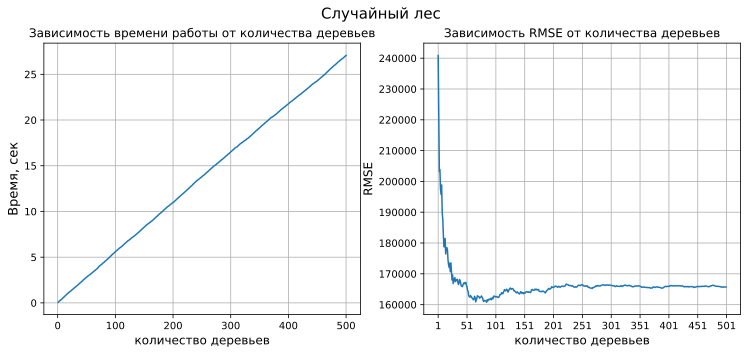

In [14]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12.5, 5))
plt.suptitle('Случайный лес', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от количества деревьев')
plt.plot([i for i in range(1,501)], history_rf_trees['time'])
plt.grid()
plt.xlabel('количество деревьев', fontsize=12)
plt.ylabel('Время, сек', fontsize=13)

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от количества деревьев')
plt.plot([i for i in range(1, 501)], history_rf_trees['rmse'])
plt.grid()
plt.xlabel('количество деревьев', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks([i for i in range(1, 521, 50)])
# plt.ylim(160000, 200000)

plt.savefig('history_rf_trees.pdf', bbox_inches="tight")
plt.show()

In [15]:
history_rf_feat = {'time': [], 'rmse': []}
feat = [1, 3, 5, 7, 10, 12, 15, 18, 20, 23]
for i in feat:
    start_time = timeit.default_timer()
    model = RandomForestMSE(n_estimators=60, feature_subsample_size=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt((((y_pred - y_test)**2).mean()))
    history_rf_feat['rmse'].append(rmse)
    history_rf_feat['time'].append(timeit.default_timer() - start_time)

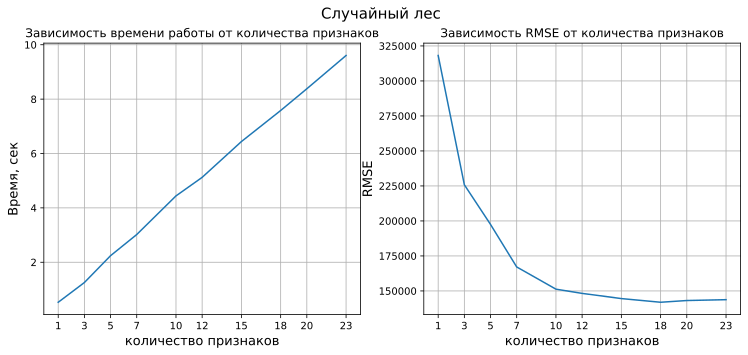

In [16]:
plt.figure(figsize=(12.5, 5))
plt.suptitle('Случайный лес', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от количества признаков')
plt.plot(feat, history_rf_feat['time'])
plt.grid()
plt.xlabel('количество признаков', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)
plt.xticks(feat)

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от количества признаков')
plt.plot(feat, history_rf_feat['rmse'])
plt.grid()
plt.xlabel('количество признаков', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.xticks(feat)

plt.savefig('history_rf_feat.pdf', bbox_inches="tight")
plt.show()

In [17]:
history_rf_depth = {'time': [], 'rmse': []}
max_depth = [1, 3, 5, 7, 10, 15,  None]
for i in max_depth:
    start_time = timeit.default_timer()
    model = RandomForestMSE(n_estimators=60, max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt((((y_pred - y_test)**2).mean()))
    history_rf_depth['rmse'].append(rmse)
    history_rf_depth['time'].append(timeit.default_timer() - start_time)

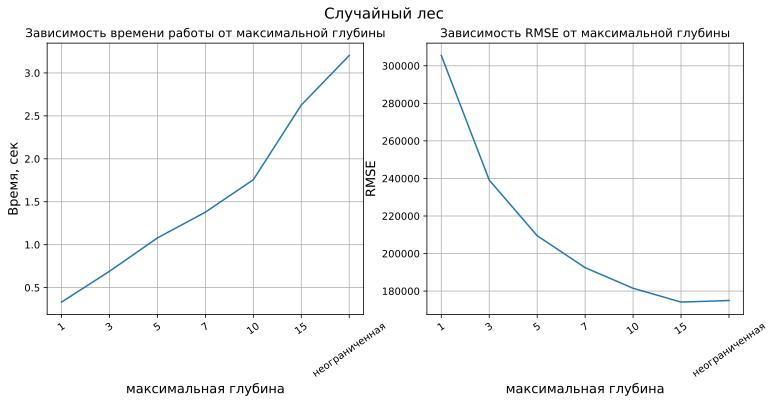

In [18]:
plt.figure(figsize=(12.5, 5))
plt.suptitle('Случайный лес', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от максимальной глубины')
plt.plot(['1', '3', '5', '7', '10', '15',  'неограниченная'], history_rf_depth['time'])
plt.grid()
plt.xlabel('максимальная глубина', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)
plt.xticks(['1', '3', '5', '7', '10', '15',  'неограниченная'], rotation=35)

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от максимальной глубины')
plt.plot(['1', '3', '5', '7', '10', '15',  'неограниченная'], history_rf_depth['rmse'])
plt.grid()
plt.xlabel('максимальная глубина', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.xticks(['1', '3', '5', '7', '10', '15',  'неограниченная'], rotation=35)

plt.savefig('history_rf_depth.pdf', bbox_inches="tight")
plt.show()

# Experiments Gradient Boosting

In [78]:
model = GradientBoostingMSE(n_estimators = 500)
history_gb_trees = model.fit(X_train, y_train, X_test, y_test)

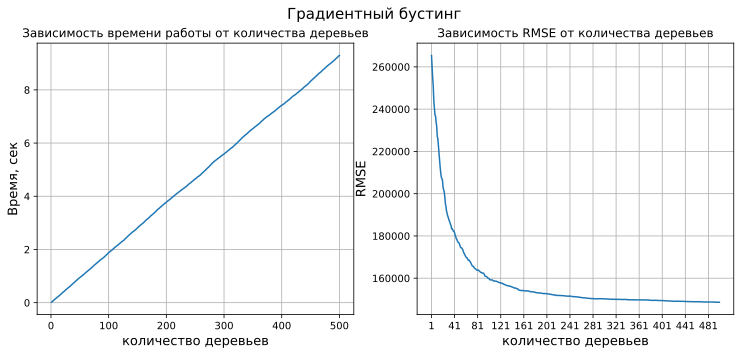

In [81]:
plt.figure(figsize=(12.5, 5))
plt.suptitle('Градиентный бустинг', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от количества деревьев')
plt.plot([i for i in range(1, 501)], history_gb_trees['time'])
plt.grid()
plt.xlabel('количество деревьев', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от количества деревьев')
plt.plot([i for i in range(1, 501)], history_gb_trees['rmse'])
plt.grid()
plt.xlabel('количество деревьев', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
# plt.ylim(200000, 220000)
plt.xticks([i for i in range(1, 510, 40)])

plt.savefig('history_gb_trees.pdf', bbox_inches="tight")
plt.show()

In [86]:
history_gb_feat = {'time': [], 'rmse': []}
feat = [i for i in range(1, 24)]
for i in feat:
    start_time = timeit.default_timer()
    model = GradientBoostingMSE(n_estimators=100, feature_subsample_size=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt((((y_pred - y_test)**2).mean()))
    history_gb_feat['rmse'].append(rmse)
    history_gb_feat['time'].append(timeit.default_timer() - start_time)

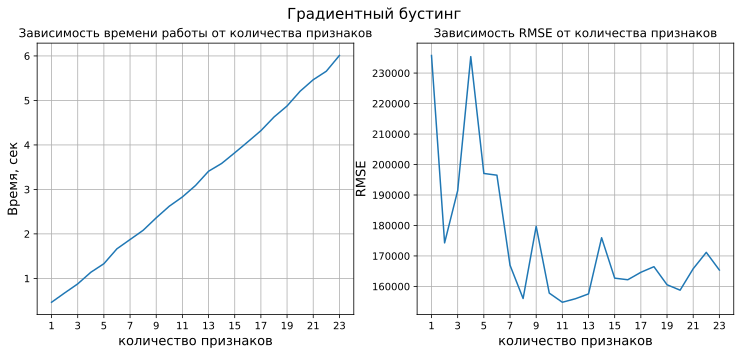

In [92]:
plt.figure(figsize=(12.5, 5))
plt.suptitle('Градиентный бустинг', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от количества признаков')
plt.plot(feat, history_gb_feat['time'])
plt.grid()
plt.xlabel('количество признаков', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)
plt.xticks([i for i in range(1,25,2)])

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от количества признаков')
plt.plot(feat, history_gb_feat['rmse'])
plt.grid()
plt.xlabel('количество признаков', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.xticks([i for i in range(1,25,2)])

plt.savefig('history_gb_feat.pdf', bbox_inches="tight")
plt.show()

In [95]:
history_gb_depth = {'time': [], 'rmse': []}
max_depth = [1, 3, 5, 7, 10, 15,  None]
for i in max_depth:
    start_time = timeit.default_timer()
    model = GradientBoostingMSE(n_estimators=100, max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt((((y_pred - y_test)**2).mean()))
    history_gb_depth['rmse'].append(rmse)
    history_gb_depth['time'].append(timeit.default_timer() - start_time)

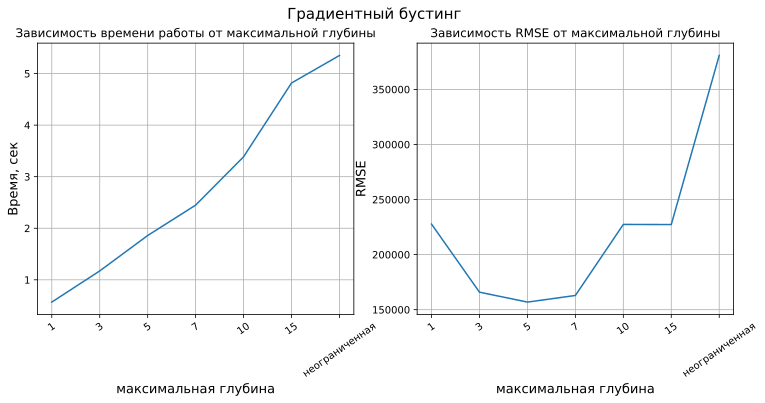

In [96]:
plt.figure(figsize=(12.5, 5))
plt.suptitle('Градиентный бустинг', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от максимальной глубины')
plt.plot(['1', '3', '5', '7', '10', '15',  'неограниченная'], history_gb_depth['time'])
plt.grid()
plt.xlabel('максимальная глубина', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)
plt.xticks(['1', '3', '5', '7', '10', '15',  'неограниченная'], rotation=35)

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от максимальной глубины')
plt.plot(['1', '3', '5', '7', '10', '15',  'неограниченная'], history_gb_depth['rmse'])
plt.grid()
plt.xlabel('максимальная глубина', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.xticks(['1', '3', '5', '7', '10', '15',  'неограниченная'], rotation=35)

plt.savefig('history_gb_depth.pdf', bbox_inches="tight")
plt.show()

In [103]:
history_gb_lr= {'time': [], 'rmse': []}
lr = [0.001, 0.01,0.05, 0.07, 0.1, 0.5, 0.7, 0.9]
for i in lr:
    start_time = timeit.default_timer()
    model = GradientBoostingMSE(n_estimators=100, learning_rate=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt((((y_pred - y_test)**2).mean()))
    history_gb_lr['rmse'].append(rmse)
    history_gb_lr['time'].append(timeit.default_timer() - start_time)

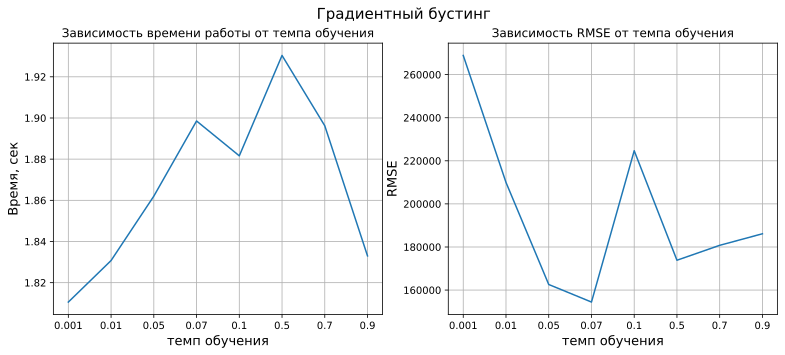

In [104]:
plt.figure(figsize=(13, 5))
plt.suptitle('Градиентный бустинг', fontsize=15)
plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от темпа обучения')
plt.plot(['0.001', '0.01', '0.05','0.07', '0.1', '0.5',  '0.7', '0.9'], history_gb_lr['time'])
plt.grid()
plt.xlabel('темп обучения', fontsize=13)
plt.ylabel('Время, сек', fontsize=13)
plt.xticks(['0.001', '0.01', '0.05','0.07',  '0.1', '0.5', '0.7', '0.9'])

plt.subplot(1, 2, 2)
plt.title('Зависимость RMSE от темпа обучения')
plt.plot(['0.001', '0.01', '0.05','0.07',  '0.1', '0.5',  '0.7', '0.9'], history_gb_lr['rmse'])
plt.grid()
plt.xlabel('темп обучения', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.xticks(['0.001', '0.01', '0.05','0.07',  '0.1', '0.5',  '0.7', '0.9'])

plt.savefig('history_gb_lr.pdf', bbox_inches="tight")
plt.show()